In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
path_to_db = "/home/rmaguado/ruben/datasets/DeepRDT_lung/"

path_to_scans = os.path.join(path_to_db, "lung")
patient_folders = [
    path for path in os.listdir(path_to_scans) \
    if os.path.isdir(os.path.join(path_to_scans, path))
]
patient_folders.sort()

path_dfs = "/home/rmaguado/cuda/AI/alba/deepRDT_lung/data/dfs"
dfs_list = [
    x.split("_")[-1].split(".")[0] \
    for x in os.listdir(path_dfs) \
    if x.endswith(".csv")
]

path_mapping = os.path.join(path_to_db, "mapping_df_lung_noDupli_wNewPatient2022.csv")
path_metadata = os.path.join(path_to_db, "DeepRDTPulmon_DATA_2024-07-17_1215.csv")

metadata = pd.read_csv(path_metadata, delimiter=";")
metadata = metadata.rename(columns={'nhc_sap': 'PID'})
metadata['PID'] = metadata['PID'].astype(int)
mapping = pd.read_csv(path_mapping)

combined = pd.merge(metadata, mapping, on='PID', how='inner')
withct = combined[combined['MAPID'].astype(str).isin(dfs_list)]
len(withct)

315

In [5]:
withct[withct['MAPID'] == 100573].iloc[0]

PID                                                                 15764
sexo                                                                    1
fecha_nacimiento                                               1942-03-22
tumor_toracico_antec                                                    2
tumor_toracico_cual                                                   NaN
                                              ...                        
estatus_visita                                                        4.0
coment_seg               - Mort sense assistència, en domicilio. UFP(2...
seguimiento_complete                                                    2
MAPID                                                              100573
MAPNAME                                                            100573
Name: 0, Length: 70, dtype: object

In [30]:
withct.columns

Index(['PID', 'sexo', 'fecha_nacimiento', 'tumor_toracico_antec',
       'tumor_toracico_cual', 'tx_local', 'tumor_extratoracico', 'tumor_cual',
       'comor_vasc', 'comor_resp', 'comor_otras', 'tabaco', 'fecha_diag',
       'edad_diag', 'pet_suv', 'carac_radio', 'ebus', 'biopsia_lesion',
       'tamano_primario', 'clin_loc_pulmonar', 't_tnm', 'n_tnm', 'm_tnm',
       'tumor_sincronico', 'fecha_analitica', 'neutrofilos', 'linfocitos',
       'plaquetas', 'fecha_espirometria', 'fvc_l', 'fvc_por', 'fev1_l',
       'fev1_por', 'dlco_num', 'dlco_por', 'motivo_no_iq___1',
       'motivo_no_iq___2', 'motivo_no_iq___3', 'motivo_no_iq___4',
       'otros_motivo_no_iq', 'fecha_ini_sbrt', 'dosis_total', 'num_sesion',
       'fecha_fin_sbrt', 'tox_sbrt', 'tipo_tox', 'tox_aguda', 'tox_cronica',
       'prueba_realizada', 'fecha_prueba', 'respuesta', 'coment_clinico',
       'datos_generales_complete', 'recaida', 'fecha_recaida',
       'loc_recaida___1', 'loc_recaida___2', 'loc_recaida___3',
    

In [3]:
def get_series_uid(mapid):
    filename = f"ct_df_filtered_{mapid}.csv"
    path_to_df = os.path.join(path_dfs, filename)
    df = pd.read_csv(path_to_df)
    return df["SeriesInstanceUID"].iloc[0]

In [4]:
sample_number = 0
sample_patient_path = os.path.join(path_to_scans, withct['MAPID'].iloc[sample_number].astype(str))
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(sample_patient_path)
len(series_IDs)

66

In [9]:
sample_patient_path

'/home/rmaguado/ruben/datasets/DeepRDT_lung/lung/100573'

In [8]:
mapid = withct['MAPID'].iloc[sample_number]
series_uid = get_series_uid(mapid)
series_uid

'2.25.998946571066760777197452923322573191127'

In [16]:
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(
    sample_patient_path, series_uid
)
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)
image = series_reader.Execute()
image_array = sitk.GetArrayViewFromImage(image).astype(np.float32)

In [17]:
image_array.shape

(113, 512, 512)

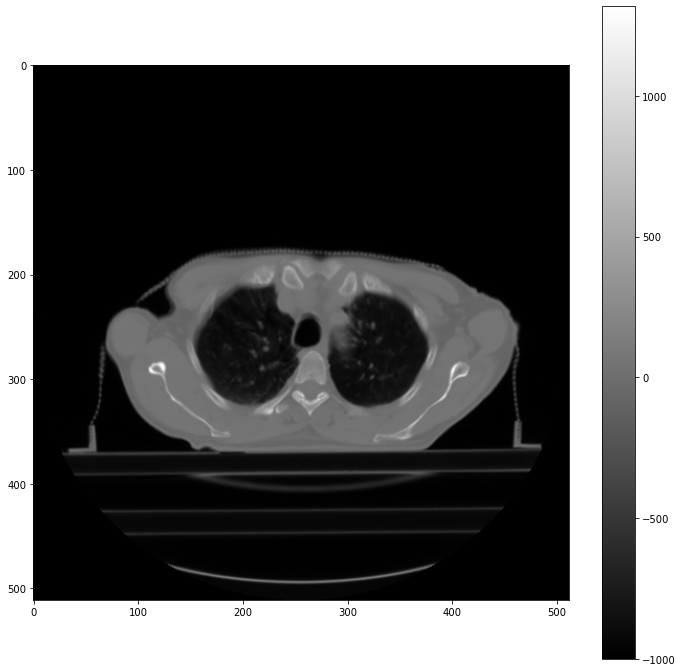

In [23]:
plt.figure(figsize=(12,12))
plt.imshow(image_array[80], cmap="gray")
plt.colorbar()
plt.show()

In [11]:
scans = []
for i, series_id in enumerate(series_IDs):
    series_reader = sitk.ImageSeriesReader()
    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(
        sample_patient_path, series_id
    )
    
    dcm = pydicom.dcmread(series_file_names[0])
    current_series_uid = dcm.get((0x0008, 0x0018))

    if current_series_uid == "CT":
        series_reader = sitk.ImageSeriesReader()
        series_reader.SetFileNames(series_file_names)
        image = series_reader.Execute()
        image_array = sitk.GetArrayViewFromImage(image).astype(np.float32)
        image_shape = image_array.shape
        scans.append((series_file_names, image_array))
    
    

In [12]:
scans

[]

In [ ]:
scan_id = -1
slice_num = 0

series_num, series_file_names, image_array = scans[scan_id]
print("series number:", series_num)
print("shape:", image_array.shape)
plt.figure(figsize=(12,12))
plt.imshow(image_array[slice_num], cmap="gray")
plt.colorbar()
plt.show()

In [ ]:
dcm = pydicom.dcmread(series_file_names[0])
dcm

In [ ]:
dcm = pydicom.dcmread(series_file_names[0])
dcm